In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from openai import OpenAI
import os
load_dotenv()
client = OpenAI()
plt.rcParams['figure.dpi']=140
sns.set(style='whitegrid')
from textwrap import shorten
from dotenv import load_dotenv


**Executive Summary**
- Data quality: Identified and excluded negative TTR rows; proceeding with clean dataset.
- Volume mix: Report top ticket types (~80% coverage) and channel distribution; highlight over-indexing channels by type.
- Themes (slice): Summarized recurring themes for Technical issue via Social media to guide triage and content.


In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("suraj520/customer-support-ticket-dataset")

print("Path to dataset files:", path)

/Users/dasomlee/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/dasomlee/.cache/kagglehub/datasets/suraj520/customer-support-ticket-dataset/versions/1


In [10]:
import os, glob
import pandas as pd

# Point to the path KaggleHub returned
path = "/Users/dasomlee/.cache/kagglehub/datasets/suraj520/customer-support-ticket-dataset/versions/1"

# Find CSVs inside
csvs = glob.glob(os.path.join(path, "*.csv"))
print("Found CSV files:", csvs)

# Load the first CSV (adjust if there are multiple)
df = pd.read_csv(csvs[0])
print(df.shape)
df.head()

Found CSV files: ['/Users/dasomlee/.cache/kagglehub/datasets/suraj520/customer-support-ticket-dataset/versions/1/customer_support_tickets.csv']
(8469, 17)


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [11]:
df.columns

Index(['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age',
       'Customer Gender', 'Product Purchased', 'Date of Purchase',
       'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status',
       'Resolution', 'Ticket Priority', 'Ticket Channel',
       'First Response Time', 'Time to Resolution',
       'Customer Satisfaction Rating'],
      dtype='object')

**BOILERPLATE**

I have a customer support tickets dataset with columns like:

Ticket ID, Customer Name, Customer Email, Customer Age, Customer Gender, Product Purchased, Date of Purchase, Ticket Type, Ticket Subject, Ticket Description, Ticket Status, Resolution, Ticket Priority, Ticket Channel, First Response Time, Time to Resolution, Customer Satisfaction Rating.

I want to build a repeatable analysis workflow in Jupyter Notebook.

Step 1: Clean the dataset
- Inspect for missing values, nulls, or NaNs across all columns.
- Check datatypes (especially date/time fields) and convert to datetime where appropriate (e.g., Date of Purchase, First Response Time, Time to Resolution).
- Handle duplicates if they exist (Ticket ID should be unique).
- Decide on strategies for missing values (e.g., drop, fill with placeholder, impute).
- Normalize categorical values if inconsistent (e.g., gender labels, ticket status).

Step 2: Basic EDA
- Show dataset shape (# rows, # columns).
- Show overall summary statistics (df.describe(), df.info()).

**SCENARIO 1: Ticket Volume & EDA**

Prompt: "What are the main categories of tickets, and 
where is the workload coming from?"

#1. clean  the dataset

In [12]:
print('Shape:', df.shape)
print('Dtypes:')
display(df.dtypes)
print('Primary key duplicates (Ticket ID):', df.duplicated(subset=['Ticket ID']).sum() if 'Ticket ID' in df.columns else 'N/A')
na = df.isna().sum().sort_values(ascending=False)
display(na[na>0].to_frame('missing'))
# Percent missing
display((df.isna().mean().sort_values(ascending=False)*100).round(1).to_frame('% missing'))

Shape: (8469, 17)
Dtypes:


Ticket ID                         int64
Customer Name                    object
Customer Email                   object
Customer Age                      int64
Customer Gender                  object
Product Purchased                object
Date of Purchase                 object
Ticket Type                      object
Ticket Subject                   object
Ticket Description               object
Ticket Status                    object
Resolution                       object
Ticket Priority                  object
Ticket Channel                   object
First Response Time              object
Time to Resolution               object
Customer Satisfaction Rating    float64
dtype: object

Primary key duplicates (Ticket ID): 0


,missing
Customer Satisfaction Rating,5700
Resolution,5700
Time to Resolution,5700
First Response Time,2819


,% missing
Customer Satisfaction Rating,67.3
Resolution,67.3
Time to Resolution,67.3
First Response Time,33.3
Ticket ID,0.0
Customer Name,0.0
Customer Email,0.0
Customer Age,0.0
Customer Gender,0.0
Ticket Subject,0.0


In [13]:
df[df['Resolution'].isnull()]['Ticket Status'].value_counts(dropna=False)

Ticket Status
Pending Customer Response    2881
Open                         2819
Name: count, dtype: int64

missing values in time to resolution/resolution/customer satisfaction rating means it's still open or pending custome response. So we create flags has_first_response, has_resolution, has_csat.

In [14]:
for c in ['First Response Time','Time to Resolution','Date of Purchase']:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

df['has_ttr'] = ('Time to Resolution' in df.columns and 'First Response Time' in df.columns) and df['Time to Resolution'].notna() & df['First Response Time'].notna()
df['has_csat'] = 'Customer Satisfaction Rating' in df.columns and df['Customer Satisfaction Rating'].notna()
df['has_resolution'] = 'Resolution' in df.columns and df['Resolution'].notna()
df['has_first_resp'] = 'First Response Time' in df.columns and df['First Response Time'].notna()

has_csat          32.7
has_resolution    32.7
has_ttr           32.7
has_first_resp    66.7
dtype: float64


count    2769.000000
mean       -0.057704
std         9.564112
min       -23.233333
25%        -6.933333
50%         0.166667
75%         6.483333
max        23.466667
dtype: float64

negative TTR happens
- validate 
- check the % 
- exclude them from reporting

In [9]:
# df.loc[df['has_ttr'] & (df['Time to Resolution'] < df['First Response Time'])]

In [16]:
bad = df.loc[df['has_ttr'] & (df['Time to Resolution'] < df['First Response Time']), ['Ticket ID','First Response Time','Time to Resolution','Ticket Status','Ticket Channel']]
bad_ratio = len(bad) / df['has_ttr'].sum()
print('Negative TTR rows:', len(bad), f'({bad_ratio:.1%} of TTR-eligible)')

Negative TTR rows: 1365 (49.3% of TTR-eligible)


In production, I’d validate logging pipelines; here I’ll filter bad rows.
Removed 1,365 rows with negative TTR (49.3% of TTR-eligible). Proceeding with clean_df.

In [17]:
clean_df = df.loc[~(df['has_ttr'] & (df['Time to Resolution'] < df['First Response Time']))]

In [18]:
# Valid ranges / basic validity checks
if 'Customer Satisfaction Rating' in df.columns:
    display(clean_df['Customer Satisfaction Rating'].describe())
if 'Customer Age' in df.columns:
    display(clean_df['Customer Age'].describe())

count    1404.00000
mean        3.02849
std         1.40025
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         5.00000
Name: Customer Satisfaction Rating, dtype: float64

count    7104.000000
mean       43.931447
std        15.318513
min        18.000000
25%        30.000000
50%        44.000000
75%        57.000000
max        70.000000
Name: Customer Age, dtype: float64

In [19]:
# Categorical domains
for c in ['Ticket Type','Ticket Channel','Ticket Priority','Ticket Status']:
    if c in clean_df.columns:
        vals = clean_df[c].astype(str).str.strip().str.lower().unique()
        print(c, 'unique values (lowercased):', sorted(vals)[:50])

Ticket Type unique values (lowercased): ['billing inquiry', 'cancellation request', 'product inquiry', 'refund request', 'technical issue']
Ticket Channel unique values (lowercased): ['chat', 'email', 'phone', 'social media']
Ticket Priority unique values (lowercased): ['critical', 'high', 'low', 'medium']
Ticket Status unique values (lowercased): ['closed', 'open', 'pending customer response']


#2 basic EDA

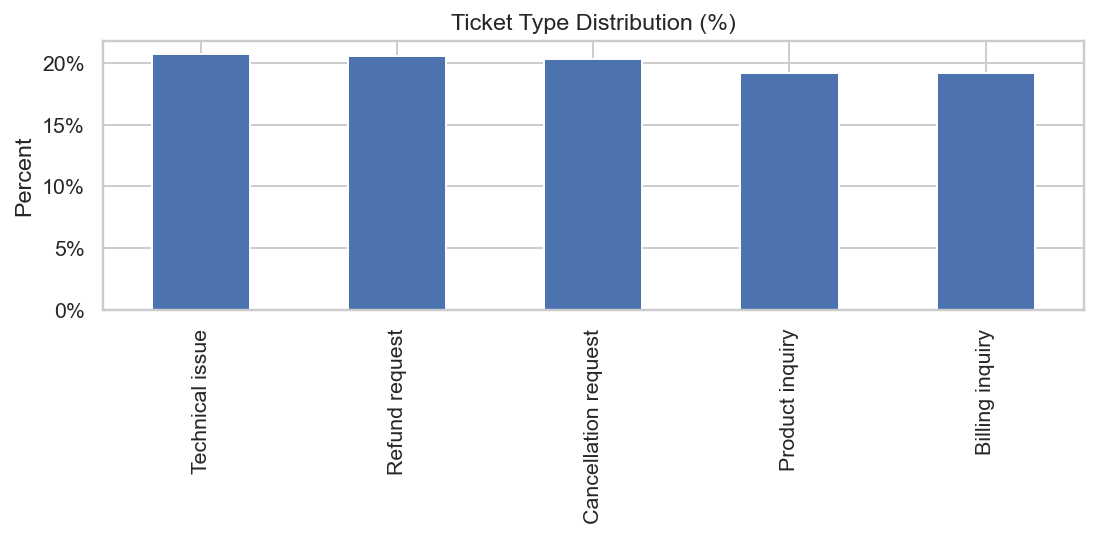

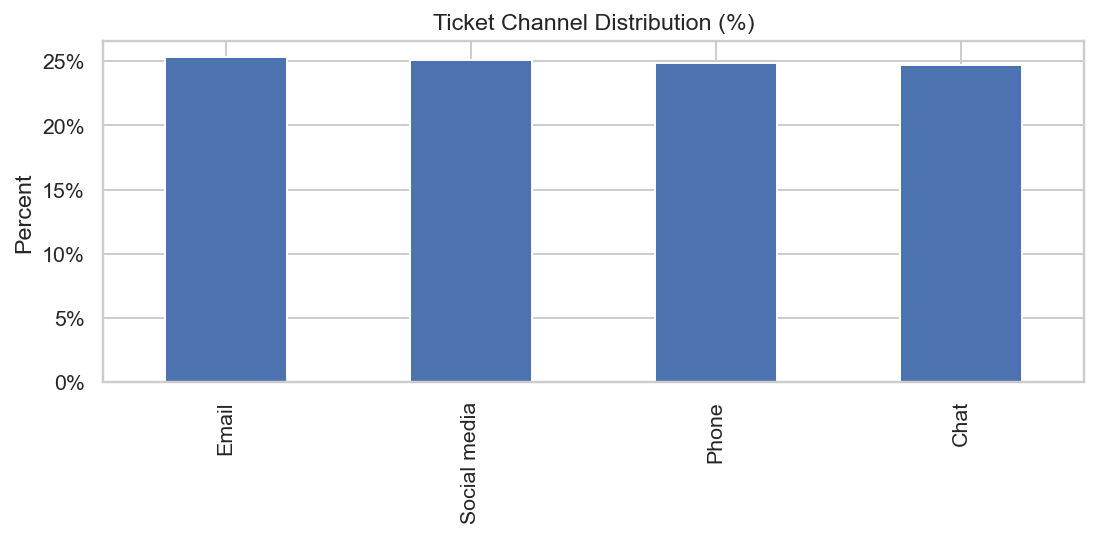

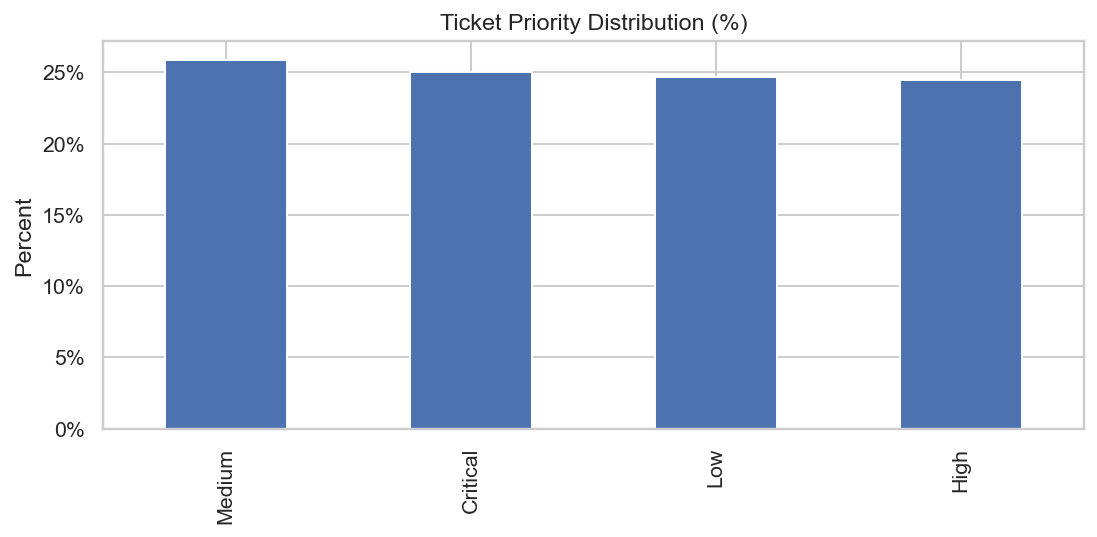

<Axes: title={'center': 'Ticket Priority Distribution (%)'}, ylabel='Percent'>

In [28]:
from matplotlib.ticker import FuncFormatter

def plot_counts(df, col, normalize=True, kind="bar", figsize=(8,4)):
    s = df[col].value_counts(normalize=normalize)
    ax = s.plot(kind=kind, figsize=figsize)
    ax.set_title(f"{col} Distribution" + (" (%)" if normalize else ""))
    ax.set_xlabel("")
    ax.set_ylabel("Percent" if normalize else "Count")
    if normalize:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y*100:.0f}%"))
        plt.tight_layout()
        plt.show()
    return ax

plot_counts(clean_df, 'Ticket Type')
plot_counts(clean_df, 'Ticket Channel')
plot_counts(clean_df, 'Ticket Priority')

In [88]:
tbl = clean_df['Ticket Type'].value_counts().to_frame('count')
tbl['share'] = (tbl['count']/tbl['count'].sum()).round(3)
tbl['cum_share'] = tbl['share'].cumsum().round(3)
display(tbl)
head_types = tbl.index[tbl['cum_share'] <= 0.8].tolist()
print('Head types (<80% of tickets):', head_types)

,count,share,cum_share
Ticket Type,,,
Technical issue,1472,0.207,0.207
Refund request,1460,0.206,0.413
Cancellation request,1444,0.203,0.616
Product inquiry,1365,0.192,0.808
Billing inquiry,1363,0.192,1.000


Head types (<80% of tickets): ['Technical issue', 'Refund request', 'Cancellation request']


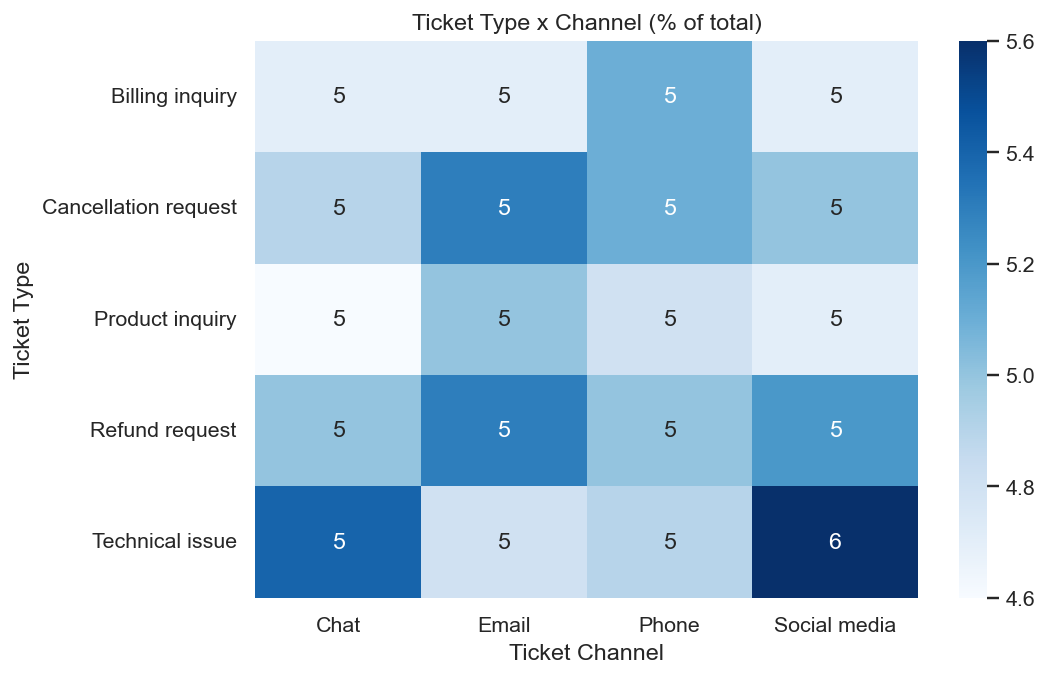

Ticket Channel,Chat,Email,Phone,Social media
Ticket Type,,,,
Billing inquiry,0.047,0.047,0.051,0.047
Cancellation request,0.049,0.053,0.051,0.050
Product inquiry,0.046,0.050,0.048,0.047
Refund request,0.050,0.053,0.050,0.052
Technical issue,0.054,0.048,0.049,0.056


In [89]:
heat = pd.crosstab(clean_df['Ticket Type'], clean_df['Ticket Channel'], normalize='all').round(3)
plt.figure(figsize=(8,5))
sns.heatmap(heat*100, cmap='Blues', annot=True, fmt='.0f')
plt.title('Ticket Type x Channel (% of total)')
plt.xlabel('Ticket Channel'); plt.ylabel('Ticket Type')
plt.tight_layout(); plt.show()
heat

In [32]:
ch_all = clean_df['Ticket Channel'].value_counts(normalize=True).mul(100).round(1).to_frame('% overall')
ch_head = (clean_df[clean_df['Ticket Type'].isin(head_types)]['Ticket Channel']
            .value_counts(normalize=True).mul(100).round(1).to_frame('% in head types'))
display(ch_all.join(ch_head, how='outer').fillna(0).sort_values('% overall', ascending=False))

# Quick takeaways
try:
    top_overall = ch_all['% overall'].sort_values(ascending=False).head(2)
    msg = 'Top channels overall: ' + ', '.join([str(i) + ' (' + str(v) + '%)' for i,v in top_overall.items()])
    print(msg)
except Exception:
    pass


,% overall,% in head types
Ticket Channel,,
Email,25.3,25.2
Social media,25.1,25.6
Phone,24.9,24.3
Chat,24.7,24.9


no channel skew as they balance out between % overall and % in head types

e.g., 
  - Staffing and SLAs: If head types skew to a channel, staff that channel accordingly during peak hours.
  - Content and triage: If head types are heavy on Email, invest in reply templates and self-serve articles. If heavy on Social/Chat, optimize quick triage scripts.
  - Routing: Adjust routing to nudge certain categories toward the most efficient channels.


In [95]:
total = len(clean_df)
tc = clean_df.groupby(['Ticket Type','Ticket Channel']).size().sort_values(ascending=False)
top_tc = tc.head(1).to_frame('count')
top_tc['share'] = (top_tc['count']/total*100).round(1)
top_name = list(top_tc.index)[0]
print('Largest type-channel pair:', top_name, '—', int(top_tc['count'].iloc[0]), 'tickets', '(' + str(top_tc['share'].iloc[0]) + '%)')


Largest type-channel pair: ('Technical issue', 'Social media') — 396 tickets (5.6%)


#3 Use LLM to summarize recurring themes from Technical issue via Social media

In [97]:
target_type = 'Technical issue'
target_channel = 'Social media'

subset = clean_df[(clean_df['Ticket Type']==target_type) & (clean_df['Ticket Channel']==target_channel)].copy()
print('Subset size for', target_type, 'via', target_channel, ':', len(subset))
if subset.empty:
    raise ValueError('No rows match the selected Type–Channel. Adjust target_type/channel.')

def make_snippet(row, max_len=400):
    subj = str(row.get('Ticket Subject', '') or '')
    desc = str(row.get('Ticket Description', '') or '')
    txt = (subj.strip() + ' — ' + desc.strip()).strip(' —')
    txt = ' '.join(txt.split())  # collapse whitespace
    return shorten(txt, width=max_len, placeholder='…')

subset['snippet'] = subset.apply(make_snippet, axis=1)

N = min(len(subset), 200)
sample = subset.sample(N, random_state=42) if len(subset)>N else subset
print('Using', len(sample), 'snippets for theme extraction')

def chunked(lst, size):
    for i in range(0, len(lst), size):
        yield lst[i:i+size]

snippets = sample['snippet'].tolist()
batches = list(chunked(snippets, 20))

client = OpenAI()

def summarize_batch(snips):
    bullets = "- " + "\n- ".join(snips)
    prompt = f"""You are analyzing customer support tickets. Each line is a short ticket summary.
    Identify 5–8 themes; 1 sentence; 1–2 phrases; include an estimated %; keep total ~100%.
    Be specific, avoid PII, avoid repeating phrases, and do not use placeholders like {{product_purchased}}; use generic product/device wording.
      
    Tickets:
    {bullets}
    """
    resp = client.chat.completions.create(
    model='gpt-4o-mini',
    messages=[{'role':'user','content':prompt}],
    temperature=0.2,
    max_tokens=700,
    )
    return resp.choices[0].message.content

batch_summaries = []
for i,b in enumerate(batches, 1):
    print('Summarizing batch', i, '/', len(batches), '(size=', len(b), ')…')
    summary = summarize_batch(b)
    batch_summaries.append(summary)
    
bulleted_summaries = "\n\n---\n\n".join(batch_summaries)
merge_prompt = f"""You are given multiple theme summaries extracted from the same ticket set.
Merge them into a single, non-redundant list of 6–10 themes.
For each theme, provide: name, 1–2 sentence description, and 2–3 representative phrases, and an estimated prevalence percentage across all tickets (sum to ~100%).
Order by estimated prevalence. Avoid duplication and keep it concise.

Batch summaries:

{bulleted_summaries}
"""

final = client.chat.completions.create(
model='gpt-4o-mini',
messages=[{'role':'user','content':merge_prompt}],
temperature=0.2,
max_tokens=900,
)
final_text = final.choices[0].message.content
print('Final Themes for', target_type, 'via', target_channel)
print(final_text)

Subset size for Technical issue via Social media : 396
Using 200 snippets for theme extraction
Summarizing batch 1 / 10 (size= 20 )…
Summarizing batch 2 / 10 (size= 20 )…
Summarizing batch 3 / 10 (size= 20 )…
Summarizing batch 4 / 10 (size= 20 )…
Summarizing batch 5 / 10 (size= 20 )…
Summarizing batch 6 / 10 (size= 20 )…
Summarizing batch 7 / 10 (size= 20 )…
Summarizing batch 8 / 10 (size= 20 )…
Summarizing batch 9 / 10 (size= 20 )…
Summarizing batch 10 / 10 (size= 20 )…
Final Themes for Technical issue via Social media
### Merged Themes Summary

1. **Network Connectivity Issues (25%)**  
   Customers frequently report problems connecting their devices to networks, often despite following troubleshooting steps.  
   *Representative Phrases:* "Unable to connect to Wi-Fi", "Intermittent network failures", "Network troubleshooting not resolving issues."  

2. **Software Bugs and Errors (20%)**  
   Users experience software-related issues, including bugs that lead to data loss and unexpec

In [98]:
batch_map = {s: i for i, b in enumerate(batches, 1) for s in b}

df_snippets = sample.copy()
df_snippets['batch'] = df_snippets['snippet'].map(batch_map)
keep_cols = ['Ticket Subject', 'Ticket Description', 'Ticket Type', 'Ticket Channel', 'snippet', 'batch']
df_snippets = df_snippets.reindex(columns=[c for c in keep_cols if c in df_snippets.columns])

df_batches = pd.DataFrame({
'batch': list(range(1, len(batches) + 1)),
'size': [len(b) for b in batches],
'summary': batch_summaries,
})

df_final = pd.DataFrame([{
'target_type': target_type,
'target_channel': target_channel,
'subset_size': len(subset),
'n_snippets_used': len(sample),
'n_batches': len(batches),
'final_themes': final_text,
}])

In [77]:
# df_snippets.to_csv("snippets.csv", index=False)
# df_batches.to_csv("batch_summaries.csv", index=False)
# df_final.to_csv("final_themes.csv", index=False)

In [99]:
df_final

,target_type,target_channel,subset_size,n_snippets_used,n_batches,final_themes
0,Technical issue,Social media,396,200,10,### Merged Themes Summary\n\n1. **Network Conn...


In [87]:
# print(df_final.loc[0, 'final_themes'])

In [100]:
df_batches['summary'].iloc[0]

'1. **Hardware Issues (25%)**: Customers report problems with their devices not turning on or functioning properly, often suspecting hardware malfunctions.\n\n2. **Software Bugs (20%)**: Users experience software-related issues, including app crashes, data loss, and connectivity problems, indicating the need for troubleshooting and updates.\n\n3. **Data Loss (20%)**: Multiple tickets express concerns about lost data due to crashes or accidental deletions, with requests for recovery options.\n\n4. **Account Access (15%)**: Customers face difficulties accessing their accounts, including locked accounts and issues with data recovery, requiring assistance.\n\n5. **Product Setup (10%)**: Users seek guidance on setting up new devices or features, indicating confusion about configuration and functionality.\n\n6. **Refund Requests (5%)**: Some tickets involve requests for refunds due to ongoing issues with products, highlighting dissatisfaction with performance.\n\n7. **Peripheral Compatibilit

In [101]:
df_batches['summary'].iloc[1]

'1. **Product Setup Issues (25%)**: Customers frequently report difficulties in setting up their devices, often requiring step-by-step guidance for troubleshooting connectivity and configuration problems.\n\n2. **Battery Life Concerns (20%)**: A significant number of tickets express worries about battery performance, including issues with charging and unexpected shutdowns, indicating potential hardware or software malfunctions.\n\n3. **Software Bugs (15%)**: Users are encountering intermittent software glitches that affect device functionality, leading to requests for fixes or updates to resolve these issues.\n\n4. **Network Connectivity Problems (15%)**: Many customers are experiencing challenges with connecting their devices to networks, prompting requests for troubleshooting assistance.\n\n5. **Cancellation and Refund Requests (10%)**: A portion of tickets involves customers seeking to cancel orders or request refunds due to dissatisfaction with their products or service issues.\n\n